# Project Idea
- A scientific organization that works to support and sustain penguin colonies. The task is to help staff members learn more about penguins in order to achieve this mission. 
- The data for this project includes datapoints across a sample size of 345 penguins, such as species, island, and sex. A K-means clustering model is required to group this data and identify patterns that provide important insights about penguins. In other words, the model is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex or not.

## **Step 1: Import Packages and Load Data** 

In [1]:
# Import standard operational packages
import numpy as np
import pandas as pd

# Important tools for modeling and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the `pandas` DataFrame 
penguins = pd.read_csv("penguins.csv")

# Display the first 10 rows
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


## **Step 2: Data Exploration (EDA)** 

In [4]:
# Find out how many penguin species there are
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [5]:
# Find the count of each species type
penguins['species'].value_counts(dropna = False)

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [11]:
# Check for missing values
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [13]:
# Drop rows with missing values
penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)

# Display the first 10 rows again to confirm no missing left in the dataFrame
penguins_subset.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
5,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
6,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
7,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female
8,Adelie,Torgersen,38.6,21.2,191.0,3800.0,male
9,Adelie,Torgersen,34.6,21.1,198.0,4400.0,male


In [17]:
# Convert `sex` column from categorical to numeric
penguins_subset = pd.get_dummies(penguins_subset, drop_first = True, columns=['sex'])

# Display the first few rows again
penguins_subset.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_male
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,1


In [18]:
# Drop the feature `island`as it cannot be used to confirm if penguins of the same species exhibit different physical characteristics based on sex
penguins_subset = penguins_subset.drop(['island'], axis=1)

### Scale the Features

- Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. We use a third-party tool, such as scikit-learn's `StandardScaler` function. `StandardScaler` scales each point xᵢ by subtracting the mean observed value for that feature and dividing by the standard deviation: 
$$
x_{\text{scaled}} = \frac{{x_i - \text{mean}(X)}}{\sigma}
$$


- This ensures that all variables have a mean of 0 and variance/standard deviation of 1. 

In [19]:
# Because the `species` column isn't a feature, it doesn't need to be scaled. So, exclude `species` variable from X
X = penguins_subset.drop(['species'], axis=1)

In [20]:
# Scale the features
X_scaled = StandardScaler().fit_transform(X)

## **Step 3: Data Modeling** 

In [43]:
# A function to fine inertia for different values of k
def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42, n_init=10)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

In [44]:
# A list to hold different numbers of K to test
num_clusters = [i for i in range(2, 11)]

# Return a list of inertia for k = 2 to 10
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[885.6224143652248,
 578.8284278107234,
 386.14534424773285,
 284.5464837898288,
 217.92858573807675,
 201.39287843423264,
 185.46131043232296,
 173.45452114979847,
 164.12001520260705]

Text(0, 0.5, 'Inertia')

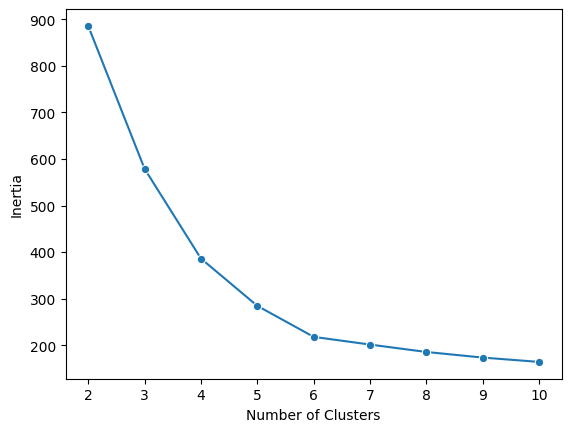

In [45]:
# Create a line plot that shows the relationship between `num_clusters` and `inertia`
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of Clusters")
plot.set_ylabel("Inertia")

**Insight:**
The plot seems to depict an elbow at six clusters, but there isn't a clear method for confirming that a six-cluster model is optimal. Therefore, the **silhouette** scores should be checked to find the distance between clusters.  

## **Step 4: Results and Evaluation** 

In [46]:
# A function to fine `silhouette` for different values of k
def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42, n_init=10)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

[0.44398088353055243,
 0.45101024097188364,
 0.5080140996630784,
 0.519998574860868,
 0.5263224884981607,
 0.47774022332151733,
 0.4221920732643224,
 0.36062890821417276,
 0.3617250563420018]

Text(0, 0.5, 'Silhouette Score')

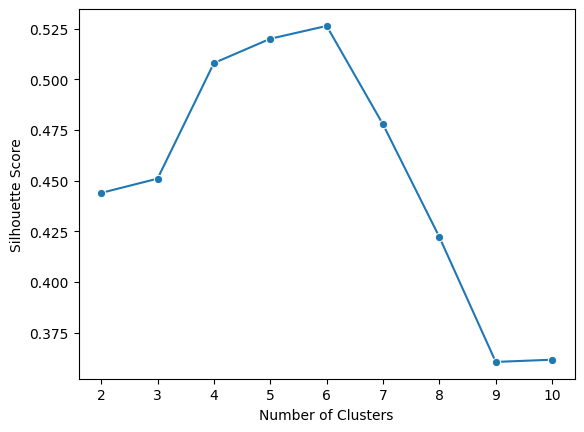

In [47]:
# Create a line plot that shows the relationship between `num_clusters` and `silhouette`
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("Number of Clusters")
plot.set_ylabel("Silhouette Score")

**Rule:**
`Silhouette` scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters. 

**Insight:**
The plot indicates that the `silhouette` score is closest to 1 when the data is partitioned into six clusters, although five clusters also yield a relatively good `silhouette` score.

In [48]:
# Fit a 6-cluster model to the dataset, considering the optimal k-value is 6
kmeans6 = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans6.fit(X_scaled)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [49]:
# Display the unique labels of the model
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


In [50]:
# Create a new column `cluster` that indicates cluster assignment in the DataFrame `penguins_subset`
penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_male,cluster
0,Adelie,39.1,18.7,181.0,3750.0,1,2
1,Adelie,39.5,17.4,186.0,3800.0,0,1
2,Adelie,40.3,18.0,195.0,3250.0,0,1
3,Adelie,36.7,19.3,193.0,3450.0,0,1
4,Adelie,39.3,20.6,190.0,3650.0,1,2


In [51]:
# Verify if any `cluster` can be differentiated by `species`
penguins_subset.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Gentoo       58
1        Adelie       73
         Chinstrap     5
2        Adelie       71
3        Adelie        2
         Chinstrap    34
4        Gentoo       61
5        Chinstrap    29
dtype: int64

<AxesSubplot: title={'center': 'Clusters differentiated by species'}, xlabel='(Cluster, Species)', ylabel='Size'>

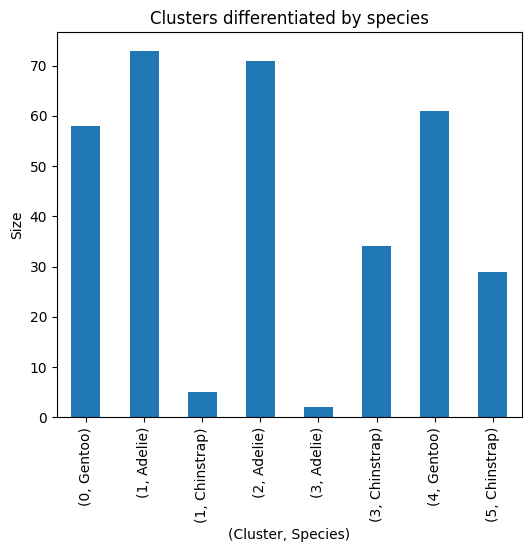

In [52]:
# Visualize these results
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters differentiated by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)')

In [53]:
# Verify if each `cluster` can be differentiated by `species` AND `sex_MALE`.
penguins_subset.groupby(by=['cluster','species', 'sex_male']).size().sort_values(ascending = False)

cluster  species    sex_male
1        Adelie     0           73
2        Adelie     1           71
4        Gentoo     1           61
0        Gentoo     0           58
3        Chinstrap  1           34
5        Chinstrap  0           29
1        Chinstrap  0            5
3        Adelie     1            2
dtype: int64

**Insight:** 
Even though clusters 1 and 3 weren't all one species or sex, the `groupby` indicates that the algorithm produced clusters mostly differentiated by species and sex. 

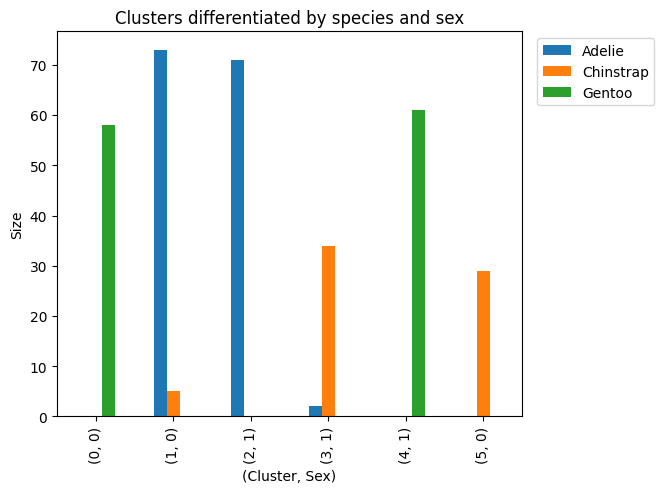

In [54]:
# Visualize these results
penguins_subset.groupby(by=['cluster','species','sex_male']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))

## **Executive Summary**

**Takeaway Keys:**
- The clusters in this project are mostly differentiated by species and sex as shown by the groupby results and corresponding graphs.
- The elbow plot and especially the silhouette scores suggests that 6 clusters are optimal for this data.
- Having 6 clusters makes sense because the study suggests that there is sexual dimorphism (differences between the sexes) for each of the three species (2 sexes * 3 different species = 6 clusters).

**Insight to Stakeholders:**
- The K-means clustering enabled this data to be effectively grouped. It helped identify patterns that can educate team members about penguins.
- The success of the cluster results suggests that the organization can apply clustering to other projects and continue augmenting employee education.